In [1]:
import numpy as np
import skimage.io
import skimage.filters
import skimage.color
import skimage.segmentation
import skimage.util
import skimage.restoration
import skimage.feature
import pandas as pd
import scipy.interpolate

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)


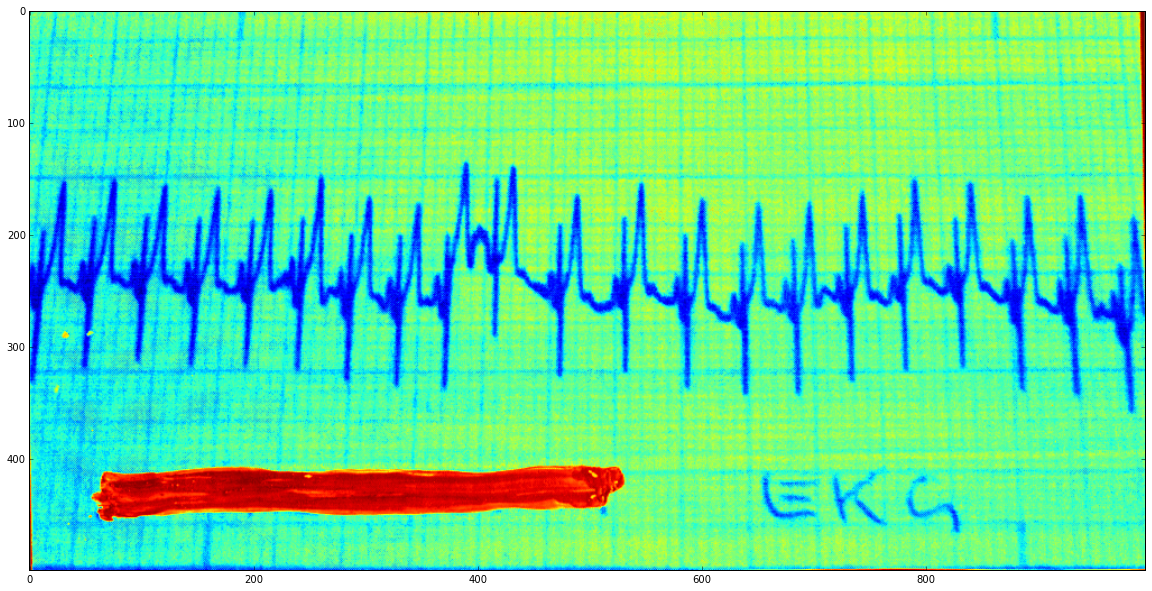

In [2]:
#load raw data
fname='../ekg-m.png'
img = skimage.io.imread(fname)
img = skimage.color.rgb2gray(img)

plt.imshow(img)

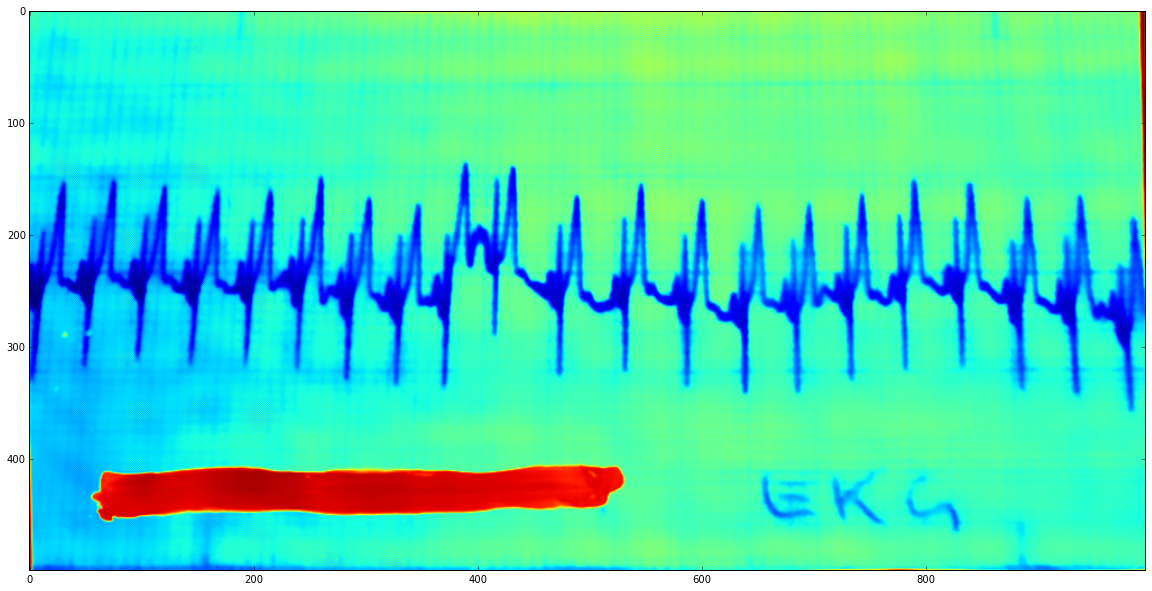

In [3]:
#denoise (ele edge detection is no good)
imgf = skimage.util.img_as_float(img)
#imgf = skimage.restoration.denoise_tv_bregman(imgf, 10.5)
denoised = skimage.restoration.nl_means_denoising(imgf,patch_size=5, patch_distance=12)
plt.imshow(denoised)

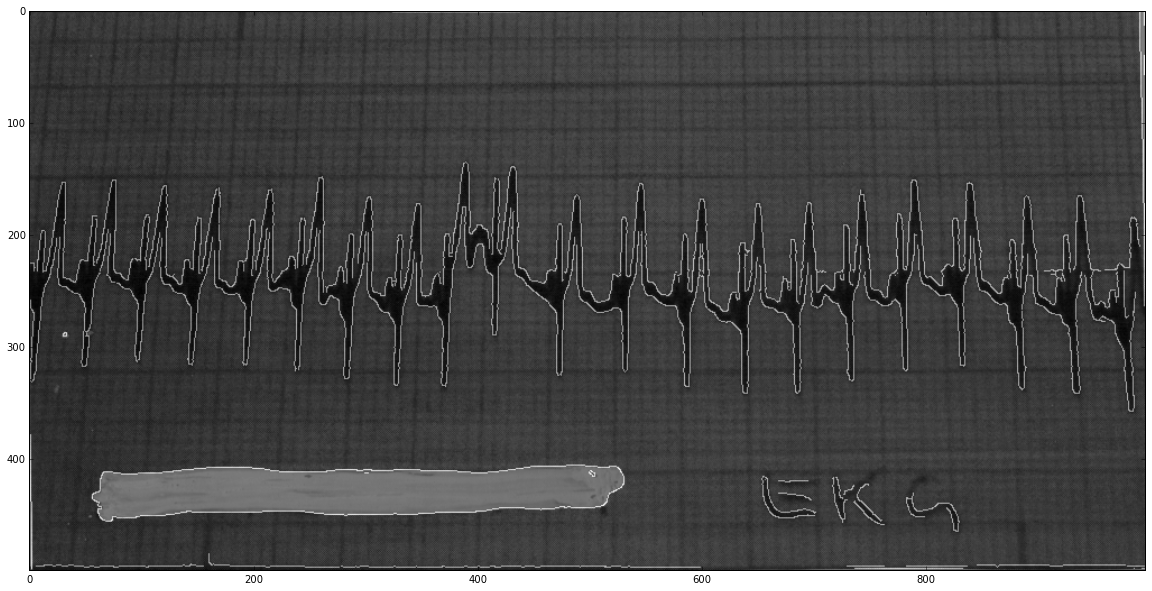

In [4]:
#find edges
edges = skimage.feature.canny(denoised,sigma=.1)
plt.imshow(edges + img, cmap=plt.cm.gray)

/home/aahu/.virtualenvs/ekg/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


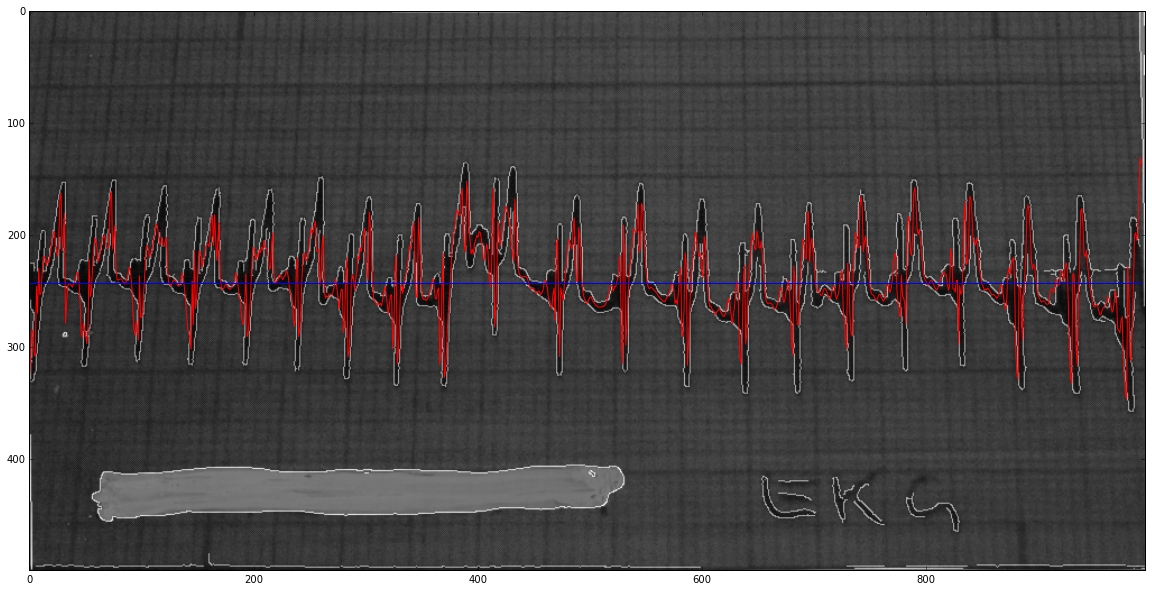

In [5]:
#use the edges to get a 1D signal out of the 2D one
xs = []
ys = []
for x in range(img.shape[1]):
    y = np.median(np.where(edges[100:400,x])[0])
    y = int(y) if not np.isnan(y) else None
    if y:
        ys.append(y)
        xs.append(x)
        
f = scipy.interpolate.interp1d(xs,ys)
line = [f(x)+100 for x in range(min(xs), max(xs))]
line = scipy.signal.wiener(line,3)
hline = np.ones_like(line)*(np.median(line))

plt.plot(line,c='r')
plt.plot(hline,c='b')
plt.imshow(img+edges,cmap=plt.cm.gray)

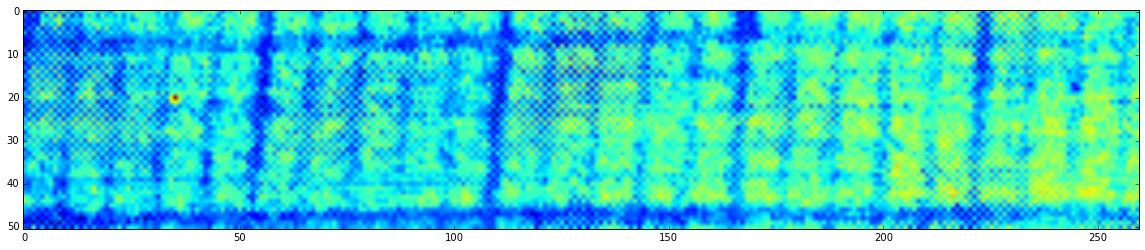

In [6]:
#trial/error to figure pixels per box... TODO statistics etc..
#I'm going to guess 55px per box (heart rate is ~300bpm?!)
#Looking at photos on crashingpatient.com suggests https://en.wikipedia.org/wiki/Supraventricular_tachycardia
box = img[20:71,0:280]
box = box[:,20:]
plt.imshow(box)
PIX_PER_BOX=55.0

In [7]:
#resample to time domain and save 
#40px is 0.2 seconds => .005 seconds per pixel in x-direction
#40px is 0.5 mV => .0125 mV per pixel in y-direction
#use median as baseline (Does this make sense?)
df = pd.DataFrame(data=line,columns=['ekg'])
df['sec'] = [(0.2/PIX_PER_BOX)*x for x in range(len(df))]
df['ekg'] = (df['ekg'] - np.median(df['ekg']))*(0.5/PIX_PER_BOX)

df.to_csv('../ekg.tsv', index=False, sep='\t')

In [8]:
df

ekg       sec
0    0.739458  0.000000
1    0.545455  0.003636
2    0.378788  0.007273
3    0.403000  0.010909
4    0.584404  0.014545
5    0.590339  0.018182
6    0.026487  0.021818
7    0.244412  0.025455
8   -0.120097  0.029091
9    0.094039  0.032727
10   0.084848  0.036364
11  -0.057576  0.040000
12  -0.215152  0.043636
13  -0.215152  0.047273
14  -0.193939  0.050909
15  -0.142424  0.054545
16  -0.184848  0.058182
17  -0.172727  0.061818
18  -0.221212  0.065455
19  -0.266667  0.069091
20  -0.372727  0.072727
21  -0.396970  0.076364
22  -0.424242  0.080000
23  -0.321212  0.083636
24  -0.254545  0.087273
25  -0.215152  0.090909
26  -0.384816  0.094545
27  -0.680913  0.098182
28  -0.728821  0.101818
29  -0.262729  0.105455
..        ...       ...
963  0.118182  3.501818
964  0.139394  3.505455
965  0.181818  3.509091
966  0.236364  3.512727
967  0.218182  3.516364
968  0.145455  3.520000
969  0.057576  3.523636
970  0.137951  3.527273
971  0.370784  3.530909
972  0.384848  3.534545
973  0.403030  3.538182
974  0.303738  3.541818
975  0.272336  3.545455
976  0.609575  3.549091
977  0.796970  3.552727
978  0.909091  3.556364
979  0.940922  3.560000
980 -0.137311  3.563636
981  0.116132  3.567273
982  0.604018  3.570909
983  0.627970  3.574545
984  0.313003  3.578182
985  0.047715  3.581818
986 -0.383099  3.585455
987 -0.409091  3.589091
988 -0.348485  3.592727
989 -0.417462  3.596364
990 -0.769697  3.600000
991 -1.019369  3.603636
992 -0.960727  3.607273

[993 rows x 2 columns]